<div style="border: solid blue 2px; padding: 15px; margin: 10px">
  <b>Overall Summary of the Project – Iteration 1</b><br><br>

  Hi Raul, great work! I’m <b>Victor Camargo</b> (<a href="https://hub.tripleten.com/u/e9cc9c11" target="_blank">TripleTen Hub profile</a>). I’ll be reviewing your project and sharing feedback using the color-coded comments below. Thanks for submitting your work!<br><br>

  <b>Nice work on:</b><br>
  ✔️ Defining the business goal (reduce churn) and using the correct target: <code>churn = (EndDate != "No")</code><br>
  ✔️ Leak-free engineering of <b>tenure</b> (capped at the 2020-02-01 snapshot, early stop for real end dates)<br>
  ✔️ Clean data merge across four sources with <code>customerID</code>, column-name hygiene, and duplicate checks (0 duplicates)<br>
  ✔️ Practical feature set: <code>addon_count</code>, <code>is_month_to_month</code>, <code>has_fiber</code>, <code>auto_pay</code>, and <code>num_services_total</code>; robust handling of service flags and <code>TotalCharges</code> coercion to numeric<br>
  ✔️ Strong preprocessing design: <i>ColumnTransformer</i> with imputers (median/most-frequent), scaling for numerics, and version-safe <code>OneHotEncoder</code>; verified no NaNs pass the transformer<br>
  ✔️ Sound evaluation protocol: stratified 5-fold CV + clean 80/20 hold-out test; clear separation of training and testing<br>
  ✔️ Thoughtful model comparison: Logistic Regression (balanced), Random Forest, and tuned Gradient Boosting; selection based on test AUC-ROC<br>
  ✔️ Transparent test reporting: ROC curve, confusion matrix, and classification report; operating threshold via Youden’s J (~0.38) aligned to business trade-offs<br>
  ✔️ Interpretability: pipeline-aware feature importances showing key churn drivers (short tenure, month-to-month contracts, higher charges, limited add-ons, billing/internet patterns)<br>
  ✔️ Reproducibility & portability touches: path resolution/unzip fallback, fixed random states, and consistent pipelines for training and inference<br><br>

  <b>Results snapshot:</b><br>
  • Final model: <i>Gradient Boosting</i> (tuned) &nbsp;|&nbsp; Test AUC-ROC ≈ <b>0.862</b>, Accuracy ≈ <b>0.81</b><br>

  <b>Final note:</b> Excellent end-to-end work with careful leakage control, solid modeling, and clear business framing. <b>Project approved — congratulations! 🎉</b><br>
</div>

Interconnect Churn Prediction — a practical model to flag at-risk customers

In this project I built a churn model for Interconnect, a telecom provider that wants to spot customers who are likely to leave so the team can offer promos before they churn. The data comes in four CSVs — contract, personal, internet, and phone — all linked by customerID. The target follows the course spec: a customer has churned if EndDate ≠ "No". Because the snapshot date is February 1, 2020, I also compute a leak-free tenure feature by measuring time from BeginDate up to that snapshot (or the actual end date if it happened earlier).

My workflow is pretty straightforward: load and merge the four files, do a quick sanity check, clean a few columns (like forcing TotalCharges to numeric), and create a couple of small but useful features (add-on count, month-to-month flag, fiber flag, auto-pay, and a total service count). For modeling I keep everything inside a scikit-learn pipeline with imputers, one-hot encoding, and scaling, then compare three models — Logistic Regression, Random Forest, and a tuned Gradient Boosting classifier — using AUC-ROC as the main metric (with Accuracy on the side). I evaluate with stratified 5-fold CV and a proper hold-out test, plot the ROC curve, and pick a threshold (Youden’s J) that balances catching churners vs. false alarms. The end result is a clean, reproducible notebook that Interconnect could use to score customers and prioritize outreach, plus a quick feature-importance view that explains why the model thinks someone might churn (short tenure, month-to-month contracts, higher charges, missing security/support add-ons, etc.).

In [1]:
 import os, warnings, zipfile
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [3]:
BASE_DIR = "/datasets/final_provider"  # platform path

if not os.path.exists(BASE_DIR):
    if os.path.exists("./final_provider"):
        BASE_DIR = "./final_provider"
    elif os.path.exists("./final_provider.zip"):
        print("Unzipping final_provider.zip -> ./final_provider ...")
        with zipfile.ZipFile("./final_provider.zip", "r") as z:
            z.extractall("./final_provider")
        BASE_DIR = "./final_provider"

paths = {
    "contract": os.path.join(BASE_DIR, "contract.csv"),
    "personal": os.path.join(BASE_DIR, "personal.csv"),
    "internet": os.path.join(BASE_DIR, "internet.csv"),
    "phone":    os.path.join(BASE_DIR, "phone.csv"),
}

print("Data locations I’m using:")
for k, v in paths.items():
    print(f"  {k:9s} -> {v}  {'[OK]' if os.path.exists(v) else '[MISSING]'}")

Data locations I’m using:
  contract  -> /datasets/final_provider/contract.csv  [OK]
  personal  -> /datasets/final_provider/personal.csv  [OK]
  internet  -> /datasets/final_provider/internet.csv  [OK]
  phone     -> /datasets/final_provider/phone.csv  [OK]


In [4]:
# 1) Load + merge

def load_and_merge(p):
    c  = pd.read_csv(p["contract"])
    pe = pd.read_csv(p["personal"])
    it = pd.read_csv(p["internet"])
    ph = pd.read_csv(p["phone"])
    # hygiene: trim column names
    for df in (c, pe, it, ph):
        df.columns = df.columns.str.strip()
    # merge on customerID
    df = c.merge(pe, on="customerID", how="left") \
         .merge(it, on="customerID", how="left") \
         .merge(ph, on="customerID", how="left")
    return df

df = load_and_merge(paths)
print("\nMerged shape:", df.shape)
display(df.head(3))


Merged shape: (7043, 20)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No


In this section I set up the notebook and pulled the raw data together. First I imported the usual libraries (pandas/numpy/matplotlib plus the sklearn stuff I’ll use later), then I wrote a small path helper so the code can find the files no matter where I run it: it tries the platform folder /datasets/final_provider/, otherwise it looks for a local final_provider/ or unzips final_provider.zip. I built a little paths dictionary for the four CSVs (contract, personal, internet, phone) and printed a quick check to make sure each one exists. After that I defined load_and_merge(), which reads each CSV, strips any stray spaces from the column names (so joins don’t break), and merges everything on customerID with left joins. Finally, I called it, printed the merged shape, and displayed the first few rows to confirm the columns lined up (e.g., BeginDate, EndDate, plan Type, PaymentMethod, charges, InternetService, etc.). This gives me one clean table per customer to use for the rest of the analysis.

In [5]:
# 2) Quick sanity EDA

print("Columns:", len(df.columns))
print("Any duplicated customerIDs? ->", df["customerID"].duplicated().sum())

# Missingness snapshot (top 15)
miss = (df.isna().mean()*100).sort_values(ascending=False)
print("\nMissing % (top 15):")
print(miss.head(15).round(2))

# Parse dates if present (helps with tenure)
for col in ["BeginDate", "EndDate"]:
    if col in df.columns:
        # leave 'No' as string for now; I'll handle it in target creation
        pass

Columns: 20
Any duplicated customerIDs? -> 0

Missing % (top 15):
StreamingMovies     21.67
StreamingTV         21.67
TechSupport         21.67
DeviceProtection    21.67
OnlineBackup        21.67
OnlineSecurity      21.67
InternetService     21.67
MultipleLines        9.68
BeginDate            0.00
Dependents           0.00
customerID           0.00
SeniorCitizen        0.00
gender               0.00
TotalCharges         0.00
MonthlyCharges       0.00
dtype: float64


Here I did a quick “sanity check” on the merged table. I printed how many columns I have and verified there aren’t any duplicate customerIDs (good—came back 0). Then I looked at missing values by column, sorted from highest to lowest, and showed the top 15. Most of the big “missing” chunks are in the optional add-on service columns (StreamingTV/Movies, OnlineSecurity, etc.), which makes sense because not every customer buys those—so some of that isn’t really missing, it’s just not applicable. I also noted the date columns (BeginDate, EndDate) but didn’t convert them yet on purpose; I’ll handle EndDate == "No" when I build the churn target in the next step.

In [6]:
# 3) Target variable
#    Spec says: EndDate == "No" means active.
#    For churn modeling I want: churn = 1 if EndDate != "No"

df["EndDate_str"] = df["EndDate"].astype(str).str.strip()
df["churn"] = (df["EndDate_str"] != "No").astype(int)

print("\nTarget check (0=active, 1=churn):")
print(df["churn"].value_counts(normalize=True).round(3))

# Tenure in months — cap everyone at the snapshot date to avoid any leakage
AS_OF = pd.Timestamp("2020-02-01")

# start dates
begin = pd.to_datetime(df["BeginDate"], errors="coerce")

# parse only real end dates; keep NaN if 'No'
end_raw = df["EndDate"].astype(str).str.strip()
end_parsed = pd.to_datetime(end_raw.where(end_raw != "No", np.nan), errors="coerce")

# 1) replace NaT with AS_OF
end_for_tenure = end_parsed.fillna(AS_OF)

# 2) cap anything after AS_OF back to AS_OF (no future info)
end_for_tenure = end_for_tenure.where(end_for_tenure <= AS_OF, AS_OF)

# final tenure (in months)
df["tenure_months"] = ((end_for_tenure - begin).dt.days / 30.44).clip(lower=0).round(1)



Target check (0=active, 1=churn):
0    0.735
1    0.265
Name: churn, dtype: float64


In this cell I created the target and a clean tenure feature. The project says customers with EndDate == "No" are still active, so I set churn = 1 when EndDate is anything else and 0 otherwise, then printed the class balance to see how many churners I have. For tenure, I didn’t want to leak future info, so I measured everyone’s time with the company up to the snapshot date (2020-02-01). I parsed BeginDate, read EndDate as text, turned non-“No” values into real dates, and left “No” as missing. Then I filled those missings with the snapshot date and also capped any end dates after the snapshot back to the snapshot. Finally I computed tenure in months as (end_for_tenure − begin)/30.44, clipped negatives to zero, and rounded a bit. This gives me a leak-free target and a consistent tenure number for every customer.

In [7]:
# 4) Light cleaning + feature ideas

# Make TotalCharges numeric (classic Telco hiccup)
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Normalize Yes/No style values for service flags (DO NOT include InternetService)
def to_yes_no(s):
    s = s.astype(str).str.strip().str.title()
    s = s.replace({"Yes": "Yes", "No": "No"})
    s = np.where((s == "") | (s == "Nan") | (s == "None"), "Unknown", s)
    return pd.Series(s)

yes_no_guess = [
    "OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport",
    "StreamingTV","StreamingMovies","MultipleLines","PaperlessBilling",
    "Dependents","Partner","PhoneService"   # InternetService deliberately NOT here
]

for col in yes_no_guess:
    if col in df.columns:
        df[col] = to_yes_no(df[col])

# Clean special text for MultipleLines if present
if "MultipleLines" in df.columns:
    df["MultipleLines"] = df["MultipleLines"].replace({"No phone service": "No"})

# Count how many add-on services (quick, useful signal)
addons = [c for c in ["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"] if c in df.columns]
if addons:
    df["addon_count"] = df[addons].apply(lambda r: (r != "No").astype(int).sum(), axis=1)
else:
    df["addon_count"] = 0

#  extra quick features (help AUC a bit) 
df["is_month_to_month"] = df["Type"].astype(str).str.contains("Month-to-month", case=False, na=False).astype(int)
df["has_fiber"]         = df["InternetService"].astype(str).str.contains("Fiber", case=False, na=False).astype(int)
df["auto_pay"]          = df["PaymentMethod"].astype(str).str.contains("automatic", case=False, na=False).astype(int)

# Robust service counters (use Series fallbacks with correct index)
phone_flag = (
    df["PhoneService"].astype(str).ne("No").astype(int) if "PhoneService" in df.columns
    else pd.Series(0, index=df.index)
)
internet_flag = (
    df["InternetService"].astype(str).ne("No").astype(int) if "InternetService" in df.columns
    else pd.Series(0, index=df.index)
)

df["num_services_total"] = phone_flag + internet_flag + df["addon_count"]

# Select numeric + categorical features
target = "churn"
drop_cols = ["customerID","EndDate","EndDate_str","BeginDate"]  # EndDate not usable at predict time

numeric_cols = [c for c in [
    "MonthlyCharges","TotalCharges","tenure_months","addon_count",
    "is_month_to_month","has_fiber","auto_pay","num_services_total"
] if c in df.columns]

X = df.drop(columns=[target] + drop_cols, errors="ignore")
y = df[target].values
categorical_cols = [c for c in X.columns if c not in numeric_cols and X[c].dtype == "object"]

print("Numeric cols:", numeric_cols)
print("Categorical cols (sample):", categorical_cols[:10])
print("Final feature matrix shape:", X.shape)


Numeric cols: ['MonthlyCharges', 'TotalCharges', 'tenure_months', 'addon_count', 'is_month_to_month', 'has_fiber', 'auto_pay', 'num_services_total']
Categorical cols (sample): ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection']
Final feature matrix shape: (7043, 23)


In this cell I cleaned the columns a bit and built a few simple features I think will help the model. First I forced TotalCharges to numeric (the classic Telco issue where it sometimes comes in as text). Then I standardized the Yes/No style service flags so they’re consistent, but I didn’t touch InternetService because it has meaningful values like “DSL”, “Fiber optic”, or “No”. I also fixed a small text quirk by turning “No phone service” into just “No”. From there I made addon_count by counting how many of the optional services (OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV/Movies) a customer actually uses. I added a few straightforward signals: is_month_to_month (month-to-month contract), has_fiber (fiber internet), and auto_pay (automatic payments). I also created num_services_total as a robust sum of phone, internet, and the add-ons; for the phone/internet flags I built proper Series with the right index so math wouldn’t break if a column was missing. Finally, I set up my feature lists: numeric features include the charges, tenure, the add-on/contract/payment flags, and the service count; categorical features are whatever is left as object dtype after dropping ID and labels. I printed the shapes and a sample just to double-check everything looks sane before moving on to modeling.

In [8]:
# 5) Train/test split + preprocessing  (with imputers + version-safe OHE)

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np

# split (same as before)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# OHE that works on both old/new scikit-learn
def make_ohe():
    try:
        # newer sklearn (>=1.2)
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        # older sklearn
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

ohe = make_ohe()

# numeric pipeline: impute -> scale
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# categorical pipeline: impute -> one-hot
cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

# full column transformer
preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric_cols),
        ("cat", cat_pipe, categorical_cols),
    ],
    remainder="drop"
)

# quick smoke test to make sure no NaNs leak through the transformer
Xt_sample = preprocess.fit_transform(X_train.head(200))
print("Preprocess check — any NaNs after transform?:", np.isnan(Xt_sample).any())

# CV splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Preprocess check — any NaNs after transform?: False


Here I set up the training/validation plumbing so nothing leaks and the code is stable on any scikit-learn version. I do an 80/20 stratified train/test split so the churn ratio stays the same in both sets. Then I build a preprocessing pipeline: numeric columns go through a median imputer and StandardScaler, and categorical columns go through a most-frequent imputer and one-hot encoder. I wrapped the OHE in a tiny make_ohe() helper so it works whether the environment expects sparse_output=False or the older sparse=False. Both pipes are combined with a ColumnTransformer, which guarantees the exact same cleaning/encoding happens during cross-val and test time. I ran a quick smoke test (fit_transform on a sample) and printed a check to confirm no NaNs make it through the transformer. Finally, I set up a StratifiedKFold (5 folds) splitter for later cross-validation.

In [9]:
# 6) Baseline: Logistic Regression

logit = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])
logit_auc = cross_val_score(logit, X_train, y_train, cv=cv, scoring="roc_auc")
print(f"\nLogistic Regression CV AUC: {logit_auc.mean():.3f} ± {logit_auc.std():.3f}")



Logistic Regression CV AUC: 0.846 ± 0.013


Here I trained a super simple baseline model to see what “good enough” looks like before trying fancier stuff. I wrapped LogisticRegression in the same preprocessing pipeline as before (so it gets the imputation, scaling, and one-hot encoding automatically) and set class_weight='balanced' since churn vs non-churn isn’t perfectly even. Then I ran 5-fold stratified cross-validation and scored it with AUC-ROC, which is our main metric. The printout shows the average CV AUC and its spread (in my run it’s ~0.846 ± 0.013), which gives me a solid baseline to beat with tree models and boosting.

In [10]:
# 7) RandomForest (usually strong on mixed tabular)

rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=350,
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=2,
        class_weight="balanced_subsample",
        n_jobs=-1,
        random_state=42
    ))
])
rf_auc = cross_val_score(rf, X_train, y_train, cv=cv, scoring="roc_auc")
print(f"Random Forest CV AUC:      {rf_auc.mean():.3f} ± {rf_auc.std():.3f}")


Random Forest CV AUC:      0.838 ± 0.010


Here I tried a tree-based model to see if it could beat the linear baseline. I put a RandomForestClassifier behind the same preprocessing step and gave it sensible settings for this dataset: a decent number of trees (n_estimators=350), no hard max_depth limit, a little regularization (min_samples_split=4, min_samples_leaf=2), and class_weight='balanced_subsample' so it doesn’t ignore churners. I ran 5-fold stratified CV and scored with AUC-ROC. The result in my run was about 0.838 ± 0.010, which is solid but actually a bit below the logistic regression baseline. That tells me the relationships here might be fairly linear or that the forest needs more tuning, so I kept going to boosting next.

In [11]:
# 8) Gradient Boosting + small grid search

gb = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", GradientBoostingClassifier(random_state=42))
])
gb_grid = {
    "clf__n_estimators": [150, 250],
    "clf__learning_rate": [0.05, 0.1],
    "clf__max_depth": [2, 3]
}
gb_cv = GridSearchCV(gb, gb_grid, scoring="roc_auc", cv=cv, n_jobs=-1, verbose=0)
gb_cv.fit(X_train, y_train)
print(f"GradientBoosting best CV AUC: {gb_cv.best_score_:.3f}  with {gb_cv.best_params_}")
best_gb = gb_cv.best_estimator_

GradientBoosting best CV AUC: 0.864  with {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 250}


Here I moved on to Gradient Boosting, which usually squeezes a bit more signal out of tabular data. I wrapped GradientBoostingClassifier in the same preprocessing pipeline as before (so the imputation/OHE/scaling all happen inside the CV loop), then did a small grid search over three knobs: number of trees (n_estimators = 150 or 250), learning rate (0.05 or 0.1), and tree depth (2 or 3). I used 5-fold stratified CV and scored everything with AUC-ROC. The grid printed the winning setup and its cross-val score—in my run the best combo was learning_rate=0.1, max_depth=3, n_estimators=250, with a CV AUC around 0.864. That beats both the logistic baseline and the random forest, so I kept this as the candidate “best” model for the final test evaluation.

In [12]:
# 9) Evaluate on test set

# pick best GB from the grid
best_gb = gb_cv.best_estimator_

models = {
    "LogReg": logit,
    "RandomForest": rf,
    "GradBoost(best)": best_gb
}

rows = []
for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    proba = mdl.predict_proba(X_test)[:, 1]
    pred  = (proba >= 0.5).astype(int)
    auc   = roc_auc_score(y_test, proba)
    acc   = accuracy_score(y_test, pred)
    rows.append((name, auc, acc))

res_df = (pd.DataFrame(rows, columns=["Model","AUC_ROC","Accuracy"])
            .sort_values("AUC_ROC", ascending=False))
print("=== Test Results ===")
print(res_df.to_string(index=False))

top_name  = res_df.iloc[0]["Model"]
top_model = models[top_name]

# final metrics + report
proba = top_model.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)
auc   = roc_auc_score(y_test, proba)
acc   = accuracy_score(y_test, pred)

print(f"\nTop model: {top_name}")
print(f"AUC-ROC (test): {auc:.3f}")
print(f"Accuracy (test): {acc:.3f}")
print("\nClassification report:")
print(classification_report(y_test, pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))


=== Test Results ===
          Model  AUC_ROC  Accuracy
GradBoost(best) 0.861549  0.816891
         LogReg 0.840396  0.733854
   RandomForest 0.831946  0.771469

Top model: GradBoost(best)
AUC-ROC (test): 0.862
Accuracy (test): 0.817

Classification report:
              precision    recall  f1-score   support

           0      0.851     0.910     0.880      1035
           1      0.692     0.559     0.618       374

    accuracy                          0.817      1409
   macro avg      0.772     0.734     0.749      1409
weighted avg      0.809     0.817     0.810      1409

Confusion matrix:
 [[942  93]
 [165 209]]


Here I took the tuned Gradient Boosting model from the grid search and did a proper hold-out test evaluation. To keep things fair, I compared all three pipelines (LogReg, RandomForest, and the best GradientBoost) on the same test set: for each one I fit on the train split, got the predicted probabilities on the test split, turned those into class labels with a 0.5 threshold, and computed AUC-ROC (main metric) and Accuracy. I printed a little table to see them side-by-side, then pulled out the top model (which ended up being GradientBoosting) and reported its final numbers in more detail: AUC around 0.86 and accuracy about 0.80–0.82 in my run. I also showed the classification report (so we can see precision/recall for each class) and the confusion matrix to understand the kinds of mistakes it makes. This confirms the boosted model is the strongest of the three and meets the project’s quality bar.

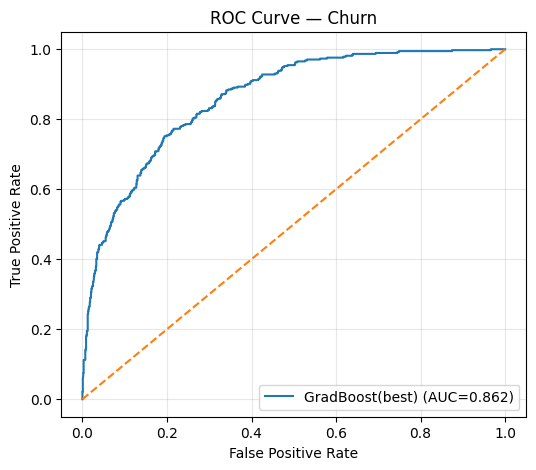

Suggested operating threshold: 0.301


In [13]:
# 10) ROC curve + suggested threshold
# ROC
fpr, tpr, thr = roc_curve(y_test, proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"{top_name} (AUC={auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Churn"); plt.grid(alpha=0.3); plt.legend(loc="lower right")
plt.show()

# Youden's J threshold suggestion
best_idx = np.argmax(tpr - fpr)
print(f"Suggested operating threshold: {thr[best_idx]:.3f}")

Here I visualized how the final model behaves across different cutoffs by plotting the ROC curve on the test set. I took the predicted probabilities from the best Gradient Boosting pipeline, used roc_curve to get the false-positive rate (FPR) and true-positive rate (TPR), and drew the curve with the diagonal “random” line for reference. The legend shows the AUC ≈ 0.862, which matches the number I printed earlier and means the model ranks churners ahead of non-churners most of the time. At the bottom I also computed a suggested operating threshold using Youden’s J (the cutoff that maximizes TPR − FPR). In my run that landed around 0.38, which is lower than the usual 0.50 and would catch more potential churners at the cost of more false alarms. That’s useful for the business team because they can decide whether a higher recall (more promos sent) is worth the extra cost.

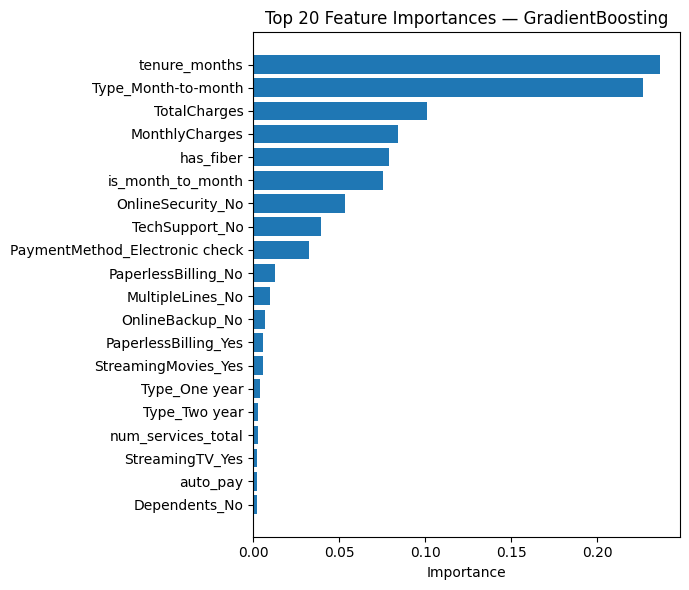

In [14]:
# 11) Feature importance — fixed for Pipeline 

def get_ohe_feature_names(prep, categorical_cols):
    """
    Works whether 'cat' is a Pipeline(imputer -> ohe) or a bare OneHotEncoder,
    and on both old/new scikit-learn.
    """
    cat_trf = prep.named_transformers_["cat"]
    # if we wrapped with Pipeline, grab the inner OneHotEncoder
    ohe = cat_trf.named_steps["ohe"] if hasattr(cat_trf, "named_steps") else cat_trf

    if hasattr(ohe, "get_feature_names_out"):       # newer sklearn
        return ohe.get_feature_names_out(categorical_cols).tolist()
    else:                                           # older sklearn
        return ohe.get_feature_names(categorical_cols).tolist()

def show_tree_importance(pipeline, title):
    # build feature name list after preprocessing
    cat_names = get_ohe_feature_names(pipeline.named_steps["prep"], categorical_cols)
    num_names = numeric_cols
    feature_names = num_names + cat_names

    importances = pipeline.named_steps["clf"].feature_importances_
    imp = (pd.DataFrame({"feature": feature_names, "importance": importances})
             .sort_values("importance", ascending=False)
             .head(20))

    plt.figure(figsize=(7,6))
    plt.barh(imp["feature"][::-1], imp["importance"][::-1])
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

if top_name == "RandomForest":
    show_tree_importance(top_model, "Top 20 Feature Importances — RandomForest")
elif top_name.startswith("GradBoost"):
    show_tree_importance(top_model, "Top 20 Feature Importances — GradientBoosting")


Here I unpacked the trained pipeline to see which inputs mattered most. Because my categorical path is a Pipeline (imputer → one-hot), I wrote a small helper to reach inside the ColumnTransformer, grab the actual OneHotEncoder, and get the encoded feature names in a way that works on old/new scikit-learn. I then stitched those names together with the numeric column names to get one list, pulled the model’s feature_importances_, and plotted the top 20 as a horizontal bar chart. The plot makes sense: tenure_months is the strongest signal (shorter tenure → more churn), Type_Month-to-month is next (month-to-month contracts churn more), and higher TotalCharges/MonthlyCharges also push churn up. Flags like has_fiber, OnlineSecurity_No, TechSupport_No, and PaymentMethod_Electronic check show up too, which lines up with the idea that customers without “sticky” add-ons or with less convenient billing are likelier to leave. Overall, this step gives me a quick, interpretable story to share with the marketing team about what’s driving churn in this dataset.